In [3]:
import sys
sys.path.insert(0, "../../face-parsing.PyTorch")
from model import BiSeNet
sys.path.insert(0, "../../generative_inpainting")
import torch
import os
import os.path as osp
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt

class FaceParsing():
    def __init__(self, checkpoint):
        n_classes = 19
        self.net = BiSeNet(n_classes=n_classes)
        # net.cuda()
        self.net.load_state_dict(torch.load(checkpoint, map_location=torch.device('cpu')))
        self.net.eval()
        self.to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

    def __inference(self, image):
        with torch.no_grad():
            cv2.imwrite("tmp.png", image)
            img = Image.open("tmp.png")
            image = img.resize((512, 512), Image.BILINEAR)
            img = self.to_tensor(image)
            img = torch.unsqueeze(img, 0)
            # img = img.cuda()
            out = self.net(img)[0]
            parsing = out.squeeze(0).cpu().numpy().argmax(0)
            return parsing
    
    def get_face_mask_512(self, image):
        assert image.shape[:2]==(512,512), f'Shape of input image should be 512x512'
        parsing_anno = self.__inference(image)
        vis_parsing_anno = parsing_anno.copy().astype(np.uint8)
        num_of_class = np.max(vis_parsing_anno)


        facemask = np.zeros(image.shape)
        for pi in [1,2,3,4,5,6,7,8,9,10,11,12,13]:
            index = np.where(vis_parsing_anno == pi)
            facemask[index[0], index[1], :] = [255,255,255]
        return facemask

    def get_face_mask(self, image, bbox):
        mask = np.zeros(image.shape)
        x1, y1, x2, y2 = map(int,bbox)
        crop = image[y1:y2, x1:x2]
        crop = cv2.resize(crop, (512, 512))
        facemask_crop = self.get_face_mask_512(crop)
        facemask_crop = cv2.resize(facemask_crop, (x2-x1, y2-y1))
        mask[y1:y2, x1:x2] = facemask_crop

        return mask

faceParsing = FaceParsing(checkpoint="../../face-parsing.PyTorch/res/cp/79999_iter.pth")

def inpaint(img, mask):
    pass

def get_crop_bbox(img, x1,y1,x2,y2):
    return img[y1:y2, x1:x2]


model_path = "/home/vuthede/Downloads/shape_predictor_81_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(model_path)
def get_landmark(im1):
    det0 = detector(im1, 0)[0]
    shape = predictor(im1, det0)
    landmarks = np.matrix([[p.x, p.y] for p in shape.parts()])
    landmarks = np.array(landmarks)
    return landmarks


def align2D(img_in, img_ref):
    """
    Find transformation from ref-->in image
    and apply it to ref image 
    81 landmarks
    """

    lm1 = get_landmark(img_ref)
    lm2 = get_landmark(img_in)

    M,loss=alignface.fit_face_landmarks(lm1[:,::-1],lm2[:,::-1], landmarks=list(range(81)), scale_landmarks=[0,16],location_landmark=30,image_dims=img_in.shape[:2])

    warp_image = alignface.warp_to_template(img_ref,M,border_value=(0.5,0.5,0.5),image_dims=img_in.shape)







Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


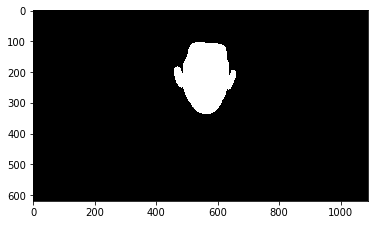

In [35]:


# img = cv2.imread("/home/vuthede/Desktop/obamafullframe.png")
# mask = faceParsing.get_face_mask(img, bbox=(400,50,800,400))
# plt.imshow(mask)